In [264]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [3]:
def read_file(filename):
    with open(filename) as f:
        for line in f:
            yield line.rstrip("\r\n")

In [4]:
def read_tsv(filename):
    train_f = read_file(filename)
    header = next(train_f).split("\t")
    train_raw = []
    for i, line in enumerate(train_f):
        sample = {
            "Index": i
        }
        for k, v in zip(header, line.split("\t")):
            sample[k] = v
        train_raw.append(sample)
    return train_raw

In [26]:
def build_index(data, key):
    index = defaultdict(list)
    for record in data:
        index[record[key]].append(record)
    return index

In [37]:
def calc_dist(coord1, coord2):
    x1, y1 = coord1
    x2, y2 = coord2
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

In [182]:
def tfloat(x):
    try:
        return float(x)
    except:
        return 0.0

In [38]:
train_raw = read_tsv("./data/train.tsv")
test_raw = read_tsv("./data/test.tsv")

In [39]:
coords = {}
for record in read_tsv("./data/train_coords.tsv"):
    coords[record["№ скважины"]] = (int(record["Координата X"]), int(record["Координата Y"]))

In [328]:
INDEX_KEY = "Index"
NAME_KEY = "Скважина"
DATE_KEY = "Дата"
Y_KEY = "Нефть, т"
W_KEY = "Вода, т"
X_KEY = "Закачка, м3"

In [41]:
train_raw_date_index = build_index(train_raw, DATE_KEY)
test_raw_date_index = build_index(test_raw, DATE_KEY)

In [323]:
train_raw_name_index = build_index(train_raw, NAME_KEY)
test_raw_name_index = build_index(test_raw, NAME_KEY)

In [401]:
name2feature = {}
feature2name = {}
next_val = 0
for record in train_raw:
    name = record[NAME_KEY]
    if name not in name2feature:
        name2feature[name] = next_val
        feature2name[next_val] = name
        next_val += 1

In [424]:
influence = {}
for name in train_raw_name_index:
    x_train = []
    y_train = []
    for record in train_raw_name_index[name]:
        y = float(record[Y_KEY])
        date = record[DATE_KEY]

        if y < 1e-6:
            continue
    
        features = np.zeros(len(name2feature))
        for record2 in train_raw_date_index[date]:
            x = float(record2[X_KEY])
            if x < 1e-6:
                continue
            features[name2feature[record2[NAME_KEY]]] = x
        
        x_train.append(features)
        y_train.append(y)
    
    if len(y_train) < 30:
        continue

    clf = Lasso(alpha=0.1)
    clf.fit(x_train, y_train)
    influence[name] = set()
    for index in clf.coef_.nonzero()[0]:
        influence[name].add(feature2name[index])

In [425]:
x_train = []
y_train = []
x_test = []
y_test = []

for record in train_raw:
    y = float(record[Y_KEY])
    date = record[DATE_KEY]
    name = record[NAME_KEY]
    coord = coords.get(name)
    h_sp = tfloat(record["Глубина спуска"])
    
    if y < 1e-6 or coord is None:
        continue
    
    features = 33 * [0.0]
    
    for record2 in train_raw_date_index[date]:
        if name in influence and record2[NAME_KEY] not in influence[name]:
            continue
        
        x = float(record2[X_KEY])
        coord2 = coords.get(record2[NAME_KEY])
        if x < 1e-6 or coord2 is None:
            continue
        
        dist = calc_dist(coord, coord2) + 1
        h_sp2 = tfloat(record2["Н сп"])
        
        features[0] += x
        features[1] += x / dist
        features[2] += x / (dist ** 0.5)
        features[3] += x / (dist ** 2)
        features[4] += x / (dist ** 3)
        features[5] += x / (dist ** 4)
        
        if h_sp2 >= h_sp:
            features[6] += x / dist
            features[7] += x / (dist ** 0.5)
            features[8] += x / (dist ** 2)
            features[9] += x / (dist ** 3)
            features[10] += x / (dist ** 4)
            features[11] += x
            
        if dist < 2000:
            features[21] += x / dist
            features[22] += x / (dist ** 0.5)
            features[23] += x / (dist ** 2)
            features[24] += x / (dist ** 3)
            features[25] += x / (dist ** 4)
            features[26] += x
        
        if dist < 2000 and h_sp2 >= h_sp:
            features[27] += x / dist
            features[28] += x / (dist ** 0.5)
            features[29] += x / (dist ** 2)
            features[30] += x / (dist ** 3)
            features[31] += x / (dist ** 4)
            features[32] += x
    
    features[12] = tfloat(record["Пластовое давление"])
    features[13] = tfloat(record["Забойное давление"])
    features[14] = tfloat(record["Производительность ЭЦН"])
    features[15] = tfloat(record["Напор"])
    features[16] = tfloat(record["Частота"])
    features[17] = tfloat(record["Буферное давление"])
    features[18] = tfloat(record["Давление в линии"])
    features[19] = tfloat(record["Давление на приеме"])
    features[20] = tfloat(record["Радиус контура питания"])

    if hash(record[NAME_KEY]) % 10 < 2:
        x_test.append(features)
        y_test.append(y)
    else:
        x_train.append(features)
        y_train.append(y)

In [428]:
clf = XGBRegressor(n_estimators=100, max_depth=4)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_train)
print(((y_pred - np.array(y_train)) ** 2).mean() ** 0.5)
y_pred = clf.predict(x_test)
print(((y_pred - np.array(y_test)) ** 2).mean() ** 0.5)

327.40178193912567
397.31612018674


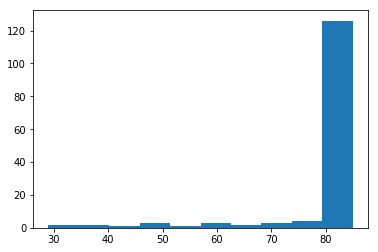

In [427]:
plt.hist([len(influence[key]) for key in influence])
plt.show()